In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# 读取数据
mnist = fetch_mldata('MNIST original',data_home='./datasets/')
# 得到数据X和标签y
X, y = mnist['data'], mnist['target']

In [3]:
# 找到正样例标签的索引
all_index_Positive = np.array(np.where(y==1)).reshape(-1).tolist()
# 找到size个正样本
index_Positive = np.random.choice(all_index_Positive, replace=False, size=3000)
# 记录其他索引
index_Unlabelled = [i for i in range(70000) if i not in index_Positive]
# 标签做拷贝用于后续对比
y_orig = y.copy()
# 标准化标签
y[index_Unlabelled] = 0
print(len(index_Positive))
print(len(index_Unlabelled))
print(y[index_Unlabelled[-1]])
print(y_orig[index_Unlabelled[-1]])

3000
67000
0.0
9.0


In [4]:
num_oob = np.zeros(shape=y.shape)
sum_oob = np.zeros(shape=y.shape)
n_estimators = 1000
dfTree = DecisionTreeClassifier()
Precision = []
Recall = []

In [5]:
for i in range(200):
    if i % 10 == 0:
        print('正在训练第%d轮' % i)
    # 1.在无标记的样本中选取和有标记样本中数量一致的样例，记录索引
    index_balance = np.random.choice(index_Unlabelled, replace=False, size=len(index_Positive))
    # 2.找到oob没被选择的无标签数据
    other_oob = list(set(index_Unlabelled) - set(index_balance))
    # 3.构建训练集
    X_train = np.concatenate((X[index_Positive], X[index_balance]), axis=0)
    y_train = np.concatenate((y[index_Positive], y[index_balance]), axis=0)
    assert(X_train.shape == (6000, 784))
    assert(y_train.shape == (6000,))
    # 4.构建测试集
    X_test = X[other_oob]
    assert(X_test.shape == (64000, 784))
    # 5.进行训练,得到训练模型
    dfTree.fit(X_train, y_train)
    # 6.预测并记录预测概率及频率
#     print(dfTree.predict_proba(X_test).shape)
#     print(dfTree.predict_proba(X_test))
    sum_oob[other_oob] += dfTree.predict_proba(X_test)[:,1]
    num_oob[other_oob] += 1
    # 7.计算每个样本的分数的平均值
    result = sum_oob / num_oob
    # 8.计算迭代n次的计算精确率（Precision）
    results = pd.DataFrame({
    'truth'      : y_orig,
    'label'      : y,
    'output_std' : result
    }, columns = ['truth', 'label', 'output_std'])
    #计算精确率（Precision）
    A_B = len(results[(results['output_std'] >= 0.3) & (results['truth'] == 1)])
    A = len(results[results['output_std'] >= 0.3])
    Precision_A_B = A_B / A * 100
#     print("直接应用标准分类器，计算精确率Precision = %.3f %%" % Precision_A_B)
    # 计算召回率（Recall）
    B = len(results[results['truth'] == 1])
    Recall_A_B = A_B / B * 100
#     print("直接应用标准分类器，计算精确率Recall = %.3f %%" % Recall_A_B)
    Precision.append(Precision_A_B)
    Recall.append(Recall_A_B)

正在训练第0轮
正在训练第10轮
正在训练第20轮
正在训练第30轮
正在训练第40轮
正在训练第50轮
正在训练第60轮
正在训练第70轮
正在训练第80轮
正在训练第90轮
正在训练第100轮
正在训练第110轮
正在训练第120轮
正在训练第130轮
正在训练第140轮
正在训练第150轮
正在训练第160轮
正在训练第170轮
正在训练第180轮
正在训练第190轮


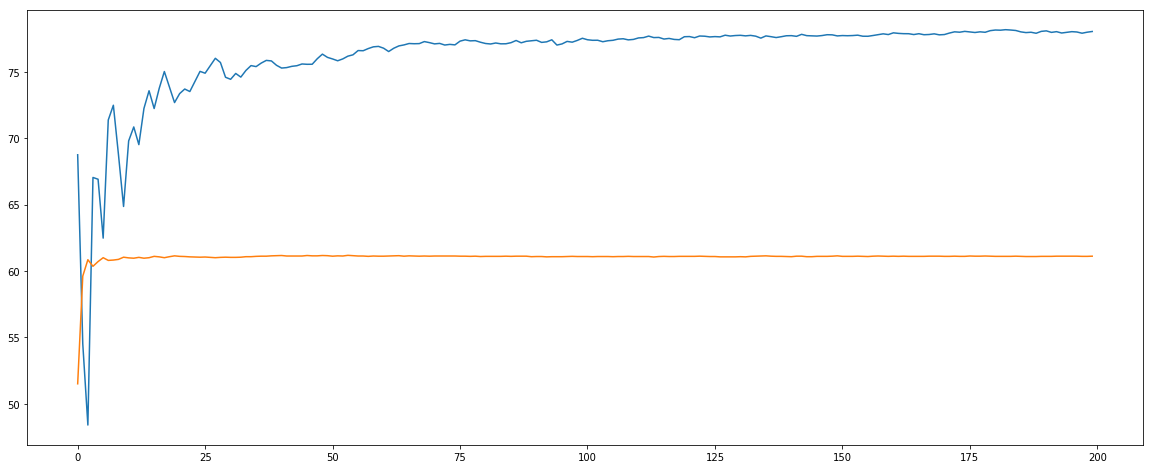

In [7]:
plt.figure(figsize=(20,8))
x = np.arange(200)
plt.plot(x, Precision, label='Precision')
plt.plot(x, Recall, label='Recall')
plt.show()